# Ratios: MS1 Spectra Based vs Spec Count Based

We will be comparing the N14:N15 ratios for peptides based on the the precursor ion intensities (MS1 spectra) and the spec counts for each.  

Only peptides that have spec counts in both searches of a given run-pair as well as an MS1 ratio will be compared.  Those without all three readings will be filtered out.

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils

In [2]:
# Load data
BASE = '../data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
grouped_loci = utils.load(os.path.join(BASE, 'grouped_loci_filt1.pkl.gz'))

Use metadata to ensure the sample labels produce correct pairing

In [3]:
grpd = metadata.groupby(['enriched', 'technical'])
pairs = []
for grp, dat in grpd:
    pairs.append(dat.index.tolist())
pairs

[['UL_Mix_1111_1', 'UL_Mix_1111_N_1'],
 ['UL_Mix_1111_2', 'UL_Mix_1111_N_2'],
 ['UL_Mix_1111_3', 'UL_Mix_1111_N_3'],
 ['UL_Mix_1121_1', 'UL_Mix_1121_N_1'],
 ['UL_Mix_1121_2', 'UL_Mix_1121_N_2'],
 ['UL_Mix_1121_3', 'UL_Mix_1121_N_3'],
 ['UL_Mix_1121_4', 'UL_Mix_1121_N_4'],
 ['UL_Mix_Pool_1', 'UL_Mix_Pool_N_1'],
 ['CL_Mix_Pool_1', 'CL_Mix_Pool_N_1'],
 ['CL_Mix_Pool_2', 'CL_Mix_Pool_N_2'],
 ['CL_Mix_Pool_3', 'CL_Mix_Pool_N_3'],
 ['CL_Mix_Pool_4', 'CL_Mix_Pool_N_4'],
 ['CL_Mix_Pool_5', 'CL_Mix_Pool_N_5']]

In [4]:
sample_names = metadata.index.tolist()

n14_samps = metadata.query('~n15').index.tolist()
n15_samps = metadata.query('n15').index.tolist()

unenr_n14 = metadata.query('~enriched and ~n15').index.tolist()
unenr_n15 = metadata.query('~enriched and n15').index.tolist()
enr_n14 = metadata.query('enriched and ~n15').index.tolist()
enr_n15 = metadata.query('enriched and n15').index.tolist()

Starting by transforming the data into a form that allows for easy grouping of quantificaiton data by sample

In [5]:
def format_qdict(qdict):
    reform = defaultdict(dict)
    for sampName, sampDict in qdict.items():
        for seqName, seqDict in sampDict.items():
            for qType, qVal in seqDict.items():
                reform[(sampName, qType)].update({seqName:qVal})
    return pd.DataFrame(reform)

peptides = defaultdict(dict)
for locus in grouped_loci:
    for samp, peps in locus.cluster_peptides.items():
        for pep, qvals in peps.items():
            peptides[pep].update({samp: qvals})
peptides = pd.DataFrame(format_qdict(peptides)).loc[sample_names]
peptides.head(4)

AAAAISIIGGADGPTSIFLAGK                       AAAANIVPNSTGAAK  \
                           back_calc counts ratio reg_fact       back_calc   
UL_Mix_1111_1                    NaN    NaN   NaN      NaN             4.0   
UL_Mix_1111_2                    NaN    NaN   NaN      NaN             8.0   
UL_Mix_1111_3                    NaN    NaN   NaN      NaN             7.0   
UL_Mix_1121_1                    NaN    NaN   NaN      NaN             2.0   

                                    AAAASLGEHILTLQK          ...     \
              counts ratio reg_fact       back_calc counts   ...      
UL_Mix_1111_1    4.0   1.8      0.0             NaN    NaN   ...      
UL_Mix_1111_2    8.0   2.6      0.0             6.0    6.0   ...      
UL_Mix_1111_3    7.0   2.4      0.0             6.0    6.0   ...      
UL_Mix_1121_1    2.0   1.4      0.0             2.0    2.0   ...      

              YYVLGATFYPGPECER          YYVPYGGPRPESYR                   \
                         ratio reg_fact      back_calc counts     ratio   
UL_Mix_1111_1              NaN      NaN            NaN    NaN       NaN   
UL_Mix_1111_2         2.573636  0.95891            4.0    4.0  0.876248   
UL_Mix_1111_3         1.805511  0.91510            NaN    NaN       NaN   
UL_Mix_1121_1         6.454666  0.97685            NaN    NaN       NaN   

                       YYVSAPQTVDTSIKK                        
              reg_fact       back_calc counts ratio reg_fact  
UL_Mix_1111_1      NaN             NaN    NaN   NaN      NaN  
UL_Mix_1111_2  0.97181             NaN    NaN   NaN      NaN  
UL_Mix_1111_3      NaN             NaN    NaN   NaN      NaN  
UL_Mix_1121_1      NaN             1.0    1.0   1.2      0.0  

[4 rows x 37344 columns]

### Comparing the ratios

In [6]:
peps = []
# Separate the peptide quants from each sample and stack into the index
for pair in pairs:
    # Divide N14/N15 for spec count values
    tmp = peptides.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    # Keep N14 value for any MS1 based ratios
    # Reg fact is important because a 0 reg.fact means inferred ratios: we will drop these values in a later step.
    tmp1 = peptides.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

# Remove inf and -inf: only occur if there is 0 counts for N15 sample
peps = (pd.concat(peps)
          .replace(np.inf, np.nan)
          .replace(-1*np.inf, np.nan)
          .dropna())
peps.head(10)

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


,back_calc,counts,ratio,reg_fact
AAAINIIPHSTGAAK,3.620134,1.363636,2.978848,0.90712
AAAQNTIPHSTGAAK,2.642190,7.000000,2.481862,0.96918
AAGVALVGGDGR,0.260274,0.500000,0.215582,0.91011
AASALCAGVR,0.100168,1.000000,0.096366,0.98082
AASATLPPITVTPVVNK,1.914523,5.000000,1.548200,0.89925
AASLGELVATHVIPR,0.344786,0.000000,0.344786,0.83950
AAWEEAEHAAK,0.777778,0.500000,0.777778,0.00000
AAYEEAEHAAK,0.802106,2.000000,0.692816,0.92938
ACDSGGILDNKPK,0.828525,1.000000,0.786931,0.97458
ACSEELGEYHVYK,4.397274,4.500000,3.824830,0.93264


Numb of peptides: 4909
Corr Coeff: 0.6090611387719008


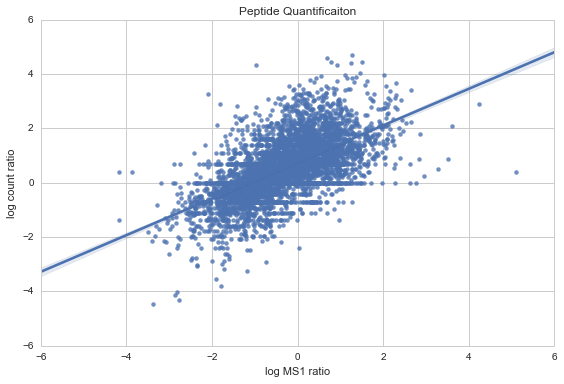

In [7]:
# Pretty Plots and Stats
import scipy
sns.set_style('whitegrid')
# Get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

# 0 Counts means no counts in N14, 0 reg fact means no real ratio.
quant_both_unorm = peps.query('reg_fact != 0 and counts != 0')
print('Numb of peptides: {}'.format(len(quant_both_unorm)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both_unorm['ratio']), np.log(quant_both_unorm['counts']))[0][1]))
sns.regplot(np.log(quant_both_unorm['ratio']), np.log(quant_both_unorm['counts']))
plt.title('Peptide Quantificaiton')
plt.xlabel('log MS1 ratio')
plt.ylabel('log count ratio');

### Normalizing the counts between N14 and N15 searches

Because there are always fewer counts in an N15 run than an N14 run, we will attempt to correct for this.  For a given run pair, we take the ratio of the total number of counts in the N15 search divided by the total number of counts for the N14 search.  This all peptide counts are then multipled by this ratio to attain a normalized count for each peptide.  


In [8]:
totals = peptides.T.unstack().apply(lambda c: c.sum())

conversion_fact = dict()
for pair in pairs:
    conversion_fact[pair[1]] = totals.loc[pair[0], 'counts'] / totals.loc[pair[1], 'counts']

conversion_fact

{'CL_Mix_Pool_N_1': 4.6031973765115799,
 'CL_Mix_Pool_N_2': 2.334696513129574,
 'CL_Mix_Pool_N_3': 4.3384670487106014,
 'CL_Mix_Pool_N_4': 5.9265070189925684,
 'CL_Mix_Pool_N_5': 8.4751415984896159,
 'UL_Mix_1111_N_1': 1.7398837823560487,
 'UL_Mix_1111_N_2': 1.7187941117160719,
 'UL_Mix_1111_N_3': 1.5944156836119834,
 'UL_Mix_1121_N_1': 1.6022400634354248,
 'UL_Mix_1121_N_2': 1.6021545319465083,
 'UL_Mix_1121_N_3': 1.5873500545256269,
 'UL_Mix_1121_N_4': 1.5049196064314856,
 'UL_Mix_Pool_N_1': 2.3942407024793386}

In [9]:
# Multiply count vales by these factors
tst = peptides.T.unstack()
for samp, fact in conversion_fact.items():
    tst.loc[:, pd.IndexSlice[samp, 'counts']] = tst.loc[:, pd.IndexSlice[samp, 'counts']]*fact

peptides_corr = tst.stack().T

In [10]:
peps = []
for pair in pairs:
    tmp = peptides_corr.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

peps = (pd.concat(peps)
          .replace(np.inf, np.nan)
          .replace(-1*np.inf, np.nan)
          .dropna())
peps.head(10)

,back_calc,counts,ratio,reg_fact
AAAINIIPHSTGAAK,3.620134,0.783751,2.978848,0.90712
AAAQNTIPHSTGAAK,2.642190,4.023257,2.481862,0.96918
AAGVALVGGDGR,0.260274,0.287376,0.215582,0.91011
AASALCAGVR,0.100168,0.574751,0.096366,0.98082
AASATLPPITVTPVVNK,1.914523,2.873755,1.548200,0.89925
AASLGELVATHVIPR,0.344786,0.000000,0.344786,0.83950
AAWEEAEHAAK,0.777778,0.287376,0.777778,0.00000
AAYEEAEHAAK,0.802106,1.149502,0.692816,0.92938
ACDSGGILDNKPK,0.828525,0.574751,0.786931,0.97458
ACSEELGEYHVYK,4.397274,2.586380,3.824830,0.93264


### Count normalized Plot

Numb of peptides: 4909
Corr Coeff: 0.6734636929033231


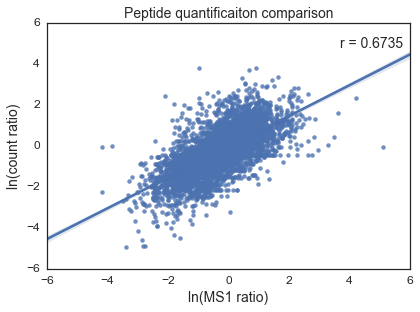

In [11]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
quant_both = peps.query('reg_fact != 0 and counts != 0')
print('Numb of peptides: {}'.format(len(quant_both)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both['ratio']), np.log(quant_both['counts']))[0][1]))
sns.regplot(np.log(quant_both['ratio']), np.log(quant_both['counts']))
plt.title('Peptide quantificaiton comparison', size = 14)
plt.xlabel('ln(MS1 ratio)', size=14)
plt.ylabel('ln(count ratio)', size=14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.text(3.7,4.8, 'r = {:1.4f}'.format(scipy.corrcoef(np.log(quant_both['ratio']), np.log(quant_both['counts']))[0][1]), size=14)

plt.savefig('count_vs_ratios.svg');

This normaliziaon helped to tighten up the graph quite a bit, increasing the correlation coefficient from .60 to .67

### See how these ratios compare at the Protein level

In [12]:
proteins = defaultdict(dict)
for locus in grouped_loci:
    for samp, qvals in locus.quantification.items():
        proteins[locus.cluster_id].update({samp: qvals})
proteins = pd.DataFrame(format_qdict(proteins))

In [13]:
totals1 = proteins.T.unstack().apply(lambda c: c.sum())

In [14]:
totals1
conversion_fact1 = dict()
for pair in pairs:
    conversion_fact1[pair[1]] = totals1.loc[pair[0], 'counts'] / totals1.loc[pair[1], 'counts']

In [15]:
conversion_fact1

{'CL_Mix_Pool_N_1': 5.6353929384965831,
 'CL_Mix_Pool_N_2': 2.5302054584483287,
 'CL_Mix_Pool_N_3': 4.4122276029055687,
 'CL_Mix_Pool_N_4': 7.1031720602371031,
 'CL_Mix_Pool_N_5': 9.1558641975308639,
 'UL_Mix_1111_N_1': 1.6369302123342271,
 'UL_Mix_1111_N_2': 1.413806158505805,
 'UL_Mix_1111_N_3': 1.4908912150829912,
 'UL_Mix_1121_N_1': 1.3792363583166725,
 'UL_Mix_1121_N_2': 1.4334230596680126,
 'UL_Mix_1121_N_3': 1.5756845186843464,
 'UL_Mix_1121_N_4': 1.2771501200395425,
 'UL_Mix_Pool_N_1': 3.1093971352117111}

In [16]:
tst = proteins.T.unstack()
for samp, fact in conversion_fact1.items():
    tst.loc[:, pd.IndexSlice[samp, 'counts']] = tst.loc[:, pd.IndexSlice[samp, 'counts']]*fact
proteins = tst.stack().T

In [17]:
prots = []
for pair in pairs:
    tmp = proteins.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = proteins.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    prots.append(tmp)

In [18]:
prots = pd.concat(prots).replace(np.inf, np.nan).replace(-1*np.inf, np.nan).dropna()

In [19]:
len(prots)

6853

In [20]:
prots.head(10)

,back_calc,counts,ratio
2011633,0.170914,0.362015,0.087153
3512858,1.286349,1.119983,1.150262
3640142,0.724960,0.763624,0.692821
3695825,0.350171,0.000000,0.362683
3762103,0.390064,0.366540,0.319297
4097327,0.398835,0.000000,0.417601
4784851,0.590375,0.447993,0.529003
5367232,1.010078,1.265435,0.938773
5564936,0.352292,0.242055,0.317968
5710574,0.273676,0.000000,0.276085


Numb of peptides: 5498
Corr Coeff: 0.6072819356421351


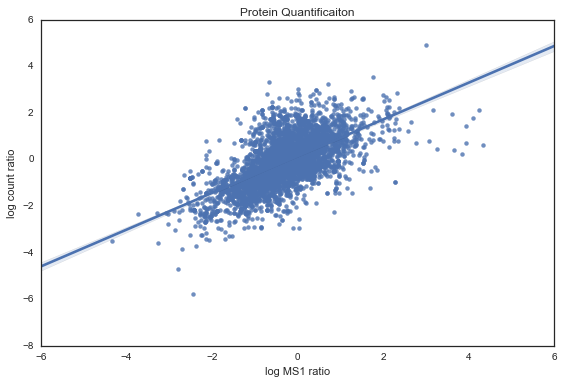

In [21]:
quant_both = prots.query('counts != 0')
print('Numb of peptides: {}'.format(len(quant_both)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both['ratio']), np.log(quant_both['counts']))[0][1]))
sns.regplot(np.log(quant_both['ratio']), np.log(quant_both['counts']))
plt.title('Protein Quantificaiton')
plt.xlabel('log MS1 ratio')
plt.ylabel('log count ratio');

## Variance Comparison - Counts vs Ratios

This time we will split the Unenriched samples from the BioGlyCMK Enriched Samples

We will use the pre-normalized counts already contained in the dataframe Peptides

In [22]:
peps = []
for n14, n15 in zip(unenr_n14, unenr_n15):
    tmp = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

In [23]:
ratio_data = pd.concat(peps, axis = 1, keys=unenr_n14).dropna(how='all')

ratio_var = ratio_data.loc[:, pd.IndexSlice[:, 'ratio']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)
count_var = ratio_data.loc[:, pd.IndexSlice[:, 'counts']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)

In [24]:
# first need to find True MS1 ratios - those have a reg_fact != 0
idx = ratio_data.loc[:, pd.IndexSlice[:, 'reg_fact']] != 0
idx.columns = idx.columns.droplevel(1)

# take those
ratio_var = ratio_data.loc[:, pd.IndexSlice[:, 'ratio']]
ratio_var.columns = ratio_var.columns.droplevel(1)

# Find the sample variance
ratio_var = ratio_var[idx].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)

# Now sample variance for counts
count_var = ratio_data.loc[:, pd.IndexSlice[:, 'counts']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)


In [25]:
var = count_var.to_frame()
var['ratio_var'] = ratio_var
var = var.rename(columns={0: 'count_var'})

In [26]:
var_filt = var.replace(0, np.nan).dropna()

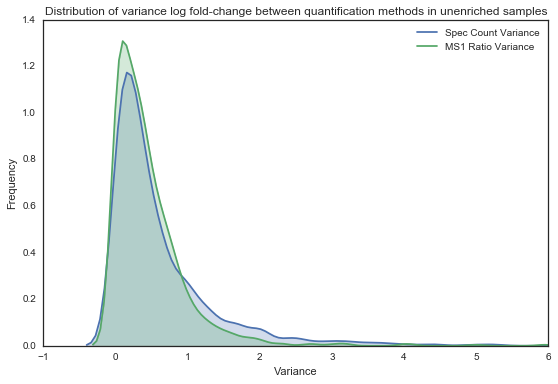

In [27]:
sns.set_style('white')
sns.kdeplot(var_filt['count_var'], shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt['ratio_var'], shade = True, label = 'MS1 Ratio Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.xlim([-1, 6])
plt.title("Distribution of variance log fold-change between quantification methods in unenriched samples");

In [28]:
# Peptides with low counts are going to be defined as those with fewer that 5 counts in both an N14 and N15 pair
# Althought these have very low counts, they may be quantifiable by MS1 ratio, which could potentailly have greater
# accuracy
def get_low_peps(cutoff = 5):
    low_peps = set()
    for pair in pairs:
        low_peps.update(set(peptides_corr.replace(0, np.nan)
                                .loc[pair, pd.IndexSlice[:, 'counts']]
                                .T.query('{0} <= {2} and {1} <= {2}'.format(pair[0], pair[1], cutoff))
                                .dropna()
                                .reset_index()['level_0']))
    return low_peps

In [29]:
low_peps = get_low_peps()
len(low_peps), peptides.shape[1]/4

(1136, 9336.0)

In [30]:
unenr_keys = unenr_n14 + unenr_n15

In [31]:
unenr_pep_num = peptides.loc[unenr_keys].dropna(axis = 1, how='all').shape[1]/4

In [32]:
var_filt.shape[0], var_filt.loc[low_peps].dropna().shape[0]

(888, 542)

In [33]:
print("Percent of petides low {0:1.2f}%".format(var_filt.loc[low_peps].dropna().shape[0]/unenr_pep_num * 100))

Percent of petides low 8.44%


#### All Peptides

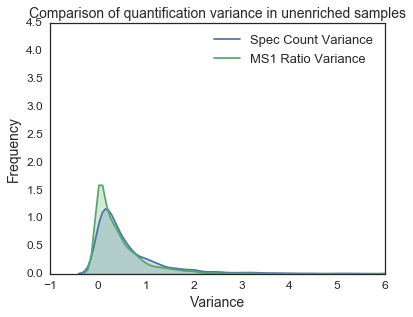

In [38]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
sns.kdeplot(var['count_var'].replace(0, np.nan).dropna(), shade = True, label = 'Spec Count Variance')
sns.kdeplot(var['ratio_var'].replace(0, np.nan).dropna(), shade = True, label = 'MS1 Ratio Variance')
fig.set_tight_layout(False)
plt.xlabel('Variance', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([-1, 6])
plt.ylim([0, 4.5])
plt.title("Comparison of quantification variance in unenriched samples", size=14)
plt.legend(prop={'size': 13})

plt.savefig('var_dist_unenriched.svg');

#### Low Count Peptides

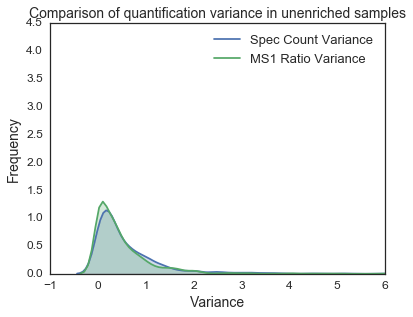

In [45]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
sns.kdeplot(var.loc[low_peps]['count_var'].replace(0, np.nan).dropna(), shade = True, label = 'Spec Count Variance')
sns.kdeplot(var.loc[low_peps]['ratio_var'].replace(0, np.nan).dropna(), shade = True, label = 'MS1 Ratio Variance')
fig.set_tight_layout(False)
plt.xlabel('Variance', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([-1, 6])
plt.ylim([0, 4.5])
plt.title("Comparison of quantification variance in unenriched samples", size=14)
plt.legend(prop={'size': 13})

plt.savefig('var_dist_unenriched.svg');

### BioGlyCMK enriched Variance

Now we will compare the variance in the ratios between technical replicaties of the BioGlyCMK enriched samples

In [39]:
peps1 = []
for n14, n15 in zip(enr_n14, enr_n15):
    tmp = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps1.append(tmp)

ratio_data1 = pd.concat(peps1, axis = 1, keys=unenr_n14)
ratio_data1 = ratio_data1.dropna(how='all')

In [40]:
# first need to find True MS1 ratios - those have a reg_fact != 0
idx = ratio_data1.loc[:, pd.IndexSlice[:, 'reg_fact']] != 0
idx.columns = idx.columns.droplevel(1)

# take those
ratio_var1 = ratio_data1.loc[:, pd.IndexSlice[:, 'ratio']]
ratio_var1.columns = ratio_var1.columns.droplevel(1)

# Find the sample variance
ratio_var1 = ratio_var1[idx].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)

# Now sample variance for counts
count_var1 = ratio_data1.loc[:, pd.IndexSlice[:, 'counts']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)


In [41]:
ratio_data1.head()

UL_Mix_1111_1                               \
                           back_calc    counts     ratio reg_fact   
AAAAISIIGGADGPTSIFLAGK      0.532635  1.086202  0.478169  0.94750   
AAAANIVPNSTGAAK                  NaN       NaN  2.800000  0.00000   
AAACSMIPTTTGAAK                  NaN       NaN  1.400000  0.00000   
AAADYLDLPLYK                0.712877       inf  0.600449  0.91776   
AAAENTIPHSTGAAK                  NaN       NaN  1.400000  0.00000   

                       UL_Mix_1111_2                           UL_Mix_1111_3  \
                           back_calc counts     ratio reg_fact     back_calc   
AAAAISIIGGADGPTSIFLAGK      0.479001    0.0  0.479001  0.89147      0.653105   
AAAANIVPNSTGAAK                  NaN    NaN  1.800000  0.00000           NaN   
AAACSMIPTTTGAAK                  NaN    NaN       NaN      NaN           NaN   
AAADYLDLPLYK                     NaN    NaN       NaN      NaN      0.744367   
AAAENTIPHSTGAAK                  NaN    NaN  1.600000  0.00000      1.446881   

                                                    UL_Mix_1121_1         \
                          counts     ratio reg_fact     back_calc counts   
AAAAISIIGGADGPTSIFLAGK       inf  0.584259  0.94583           NaN    NaN   
AAAANIVPNSTGAAK              NaN  3.800000  0.00000           NaN    NaN   
AAACSMIPTTTGAAK              NaN       NaN      NaN           NaN    NaN   
AAADYLDLPLYK            1.152481  0.643372  0.92969           NaN    NaN   
AAAENTIPHSTGAAK              inf  1.360568  0.96971           NaN    NaN   

                                      UL_Mix_1121_2                            
                       ratio reg_fact     back_calc counts     ratio reg_fact  
AAAAISIIGGADGPTSIFLAGK   5.0      0.0           NaN    NaN       NaN      NaN  
AAAANIVPNSTGAAK          1.2      0.0           NaN    NaN  1.200000  0.00000  
AAACSMIPTTTGAAK          NaN      NaN           NaN    NaN       NaN      NaN  
AAADYLDLPLYK             NaN      NaN      1.556893    inf  1.110445  0.84454  
AAAENTIPHSTGAAK          NaN      NaN           NaN    NaN       NaN      NaN

In [42]:
var1 = count_var1.to_frame()
var1['ratio_var'] = ratio_var1
var1 = var1.rename(columns={0: 'count_var'})

In [43]:
var_filt1 = var1.replace(0, np.nan).dropna()

#### All Peptides

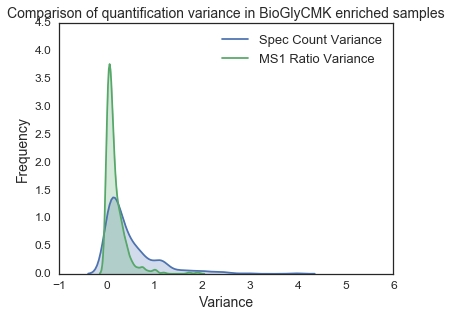

In [47]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
sns.kdeplot(var_filt1['count_var'].dropna(), shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt1['ratio_var'].dropna(), shade = True, label = 'MS1 Ratio Variance')
fig.set_tight_layout(False)
plt.xlabel('Variance', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([-1, 6])
plt.ylim([0, 4.5])
plt.title("Comparison of quantification variance in BioGlyCMK enriched samples", size=14)
plt.legend(prop={'size':13})
plt.savefig('var_dist_enriched.svg');

#### Only low count peptides

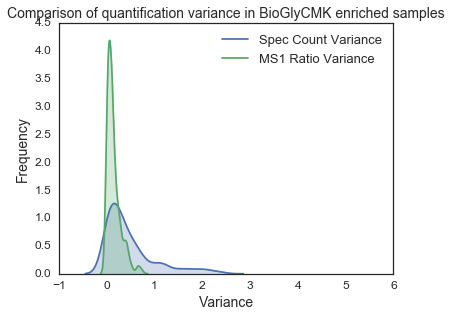

In [44]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
sns.kdeplot(var_filt1.loc[low_peps]['count_var'].dropna(), shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt1.loc[low_peps]['ratio_var'].dropna(), shade = True, label = 'MS1 Ratio Variance')
fig.set_tight_layout(False)
plt.xlabel('Variance', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([-1, 6])
plt.title("Comparison of quantification variance in BioGlyCMK enriched samples", size=14)
plt.legend(prop={'size':13})
plt.savefig('var_dist_enriched.svg');

How many peptides are in the low counts, and how many are filtered out?

In [48]:
enr_keys = enr_n14 + enr_n15
enr_pep_num = peptides.loc[enr_keys].dropna(axis = 1, how='all').shape[1]/4
var_filt1.shape[0], var_filt1.loc[low_peps].dropna().shape[0]

(385, 201)

In [51]:
print("Percent of petides quantifyable {0:1.2f}%".format(var_filt1.dropna().shape[0]/enr_pep_num * 100))

Percent of petides quantifyable 7.79%


In [53]:
print("Percent of petides low {0:1.2f}%".format(var_filt1.loc[low_peps].dropna().shape[0]/enr_pep_num * 100))

Percent of petides low 4.07%


In [53]:
print("Percent of petides low {0:1.2f}%".format(var_filt1.loc[low_peps].dropna().shape[0]/enr_pep_num * 100))

Percent of petides low 4.07%


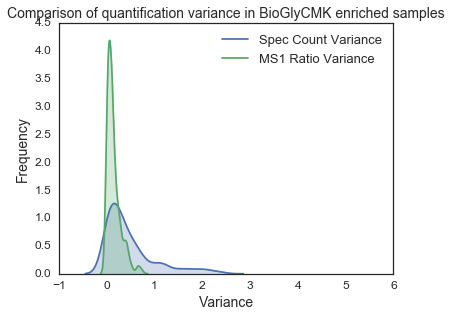

In [46]:
sns.set_style('white')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4.5)
sns.kdeplot(var_filt1.loc[low_peps]['count_var'].dropna(), shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt1.loc[low_peps]['ratio_var'].dropna(), shade = True, label = 'MS1 Ratio Variance')
fig.set_tight_layout(False)
plt.xlabel('Variance', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([-1, 6])
plt.title("Comparison of quantification variance in BioGlyCMK enriched samples", size=14)
plt.legend(prop={'size':13})
plt.savefig('var_dist_enriched.svg');

In [47]:
from scipy import stats

In [48]:
var_filt1.head(3)

,count_var,ratio_var
AAAGNIIPSSTGAAK,0.095763,0.881390
AAAINIIPHSTGAAK,0.122027,1.905591
AAAMPGADFVCLK,0.439266,0.190085
AAGIQLTPTFVK,0.053344,0.089208
AAGVALVGGDGR,0.193865,0.094225


In [50]:
stats.ks_2samp(var_filt1['count_var'], var_filt1['ratio_var'])

Ks_2sampResult(statistic=0.33766233766233766, pvalue=7.6563204590705122e-20)

In [51]:
var.head()

,count_var,ratio_var
AAAANIVPNSTGAAK,NaN,NaN
AAAASLGEHILTLQK,0.582756,0.234748
AAADELGLPLYEYLGGPNAHVLPTPMMNVINGGK,NaN,1.291436
AAADPASHQVDIALTR,NaN,NaN
AAADYLDLPLYK,0.000000,0.000000


In [52]:
ks = dict()
for i in range(1, 20):
    low_peps = get_low_peps(i+1)
    cvar = var_filt.loc[low_peps]['count_var'].dropna()
    rvar = var_filt.loc[low_peps]['ratio_var'].dropna()
    
    mean_diff = cvar.mean() - rvar.mean()
    med_diff = cvar.median() - rvar.median()
    
    res = stats.mannwhitneyu(cvar, rvar)
    
    ks[i+1] = {'stat': res[0], 'pval': res[1], 'mean_d': mean_diff, 'med_d': med_diff}
ks
dat = pd.DataFrame(ks).T.reset_index().rename(columns=({'index':'cutoff'}))


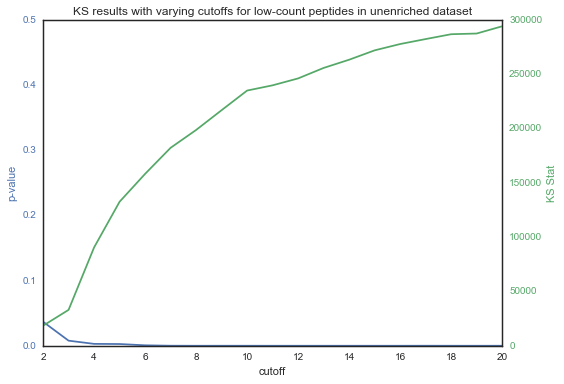

In [53]:
fig, ax1 = plt.subplots()

c1 = sns.color_palette()[0]
ax1.plot(dat['cutoff'], dat['pval'], color=c1)
ax1.set_ylabel('p-value', color=c1)
ax1.set_ylim(0, .5)
for tl in ax1.get_yticklabels():
    tl.set_color(c1)

ax2 = ax1.twinx()
c2 = color=sns.color_palette()[1]
ax2.plot(dat['cutoff'], dat['stat'], color=c2)
ax2.set_ylabel('KS Stat', color=c2)
for tl in ax2.get_yticklabels():
    tl.set_color(c2)
    
plt.title('KS results with varying cutoffs for low-count peptides in unenriched dataset')
ax1.set_xlabel('cutoff');

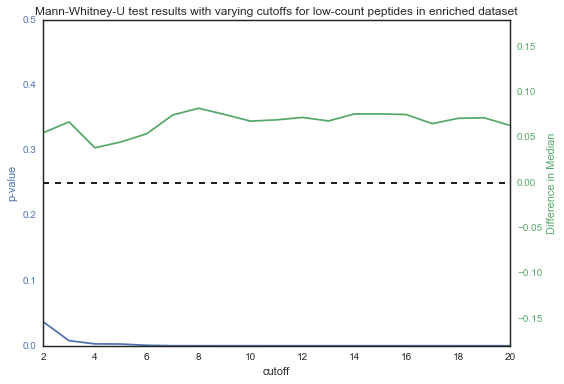

In [54]:
fig, ax1 = plt.subplots()

c1 = sns.color_palette()[0]
ax1.plot(dat['cutoff'], dat['pval'], color=c1)
ax1.set_ylabel('p-value', color=c1)
ax1.set_ylim(0, .5)
for tl in ax1.get_yticklabels():
    tl.set_color(c1)

ax2 = ax1.twinx()
c2 = color=sns.color_palette()[1]
ax2.plot(dat['cutoff'], dat['med_d'], color=c2)
ax2.set_ylabel('Difference in Median', color=c2)
ax2.set_ylim(-.18, .18)
ax2.plot((2, 20), (0,0), 'k--')
for tl in ax2.get_yticklabels():
    tl.set_color(c2)
    
plt.title('Mann-Whitney-U test results with varying cutoffs for low-count peptides in enriched dataset')
ax1.set_xlabel('cutoff');

In [55]:
ks1 = dict()
for i in range(1, 20):
    low_peps = get_low_peps(i+1)
    cvar1 = var_filt1.loc[low_peps]['count_var'].dropna()
    rvar1 = var_filt1.loc[low_peps]['ratio_var'].dropna()
    
    mean_diff = cvar1.mean() - rvar1.mean()
    med_diff = cvar1.median() - rvar1.median()
    
    res = stats.mannwhitneyu(cvar1, rvar1)
    
    ks1[i+1] = {'stat': res[0], 'pval': res[1], 'mean_d': mean_diff, 'med_d': med_diff}
ks1

{2: {'mean_d': 0.4068861904042943,
  'med_d': 0.16027104873238202,
  'pval': 7.2535055719090452e-09,
  'stat': 564.0},
 3: {'mean_d': 0.3751117525008843,
  'med_d': 0.19370376082439367,
  'pval': 6.1253709141690414e-10,
  'stat': 1327.0},
 4: {'mean_d': 0.36465614110578337,
  'med_d': 0.1991388389676519,
  'pval': 1.7605363467160137e-10,
  'stat': 4391.0},
 5: {'mean_d': 0.33269008073860978,
  'med_d': 0.1917217572746966,
  'pval': 1.5266439491720385e-14,
  'stat': 11352.0},
 6: {'mean_d': 0.32581471447641708,
  'med_d': 0.19827499995531192,
  'pval': 8.7086376116340733e-17,
  'stat': 13799.0},
 7: {'mean_d': 0.32433586677843146,
  'med_d': 0.19827499995531192,
  'pval': 2.7959627776150305e-18,
  'stat': 15356.0},
 8: {'mean_d': 0.32788741908543051,
  'med_d': 0.2025430063000403,
  'pval': 8.169569974792936e-20,
  'stat': 16817.0},
 9: {'mean_d': 0.33098440157090969,
  'med_d': 0.2021118073738882,
  'pval': 3.6773571963168043e-20,
  'stat': 19734.0},
 10: {'mean_d': 0.31707765490311801

In [56]:
dat1 = pd.DataFrame(ks1).T.reset_index().rename(columns=({'index':'cutoff'}))

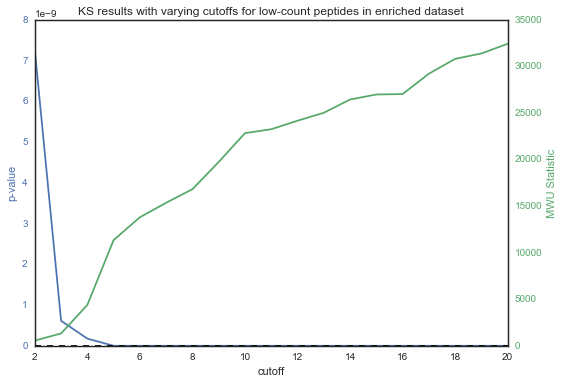

In [57]:
fig, ax1 = plt.subplots()

c1 = sns.color_palette()[0]
ax1.plot(dat1['cutoff'], dat1['pval'], color=c1)
ax1.set_ylabel('p-value', color=c1)
#ax1.set_ylim(0, .00023)
for tl in ax1.get_yticklabels():
    tl.set_color(c1)

ax2 = ax1.twinx()
c2 = color=sns.color_palette()[1]
ax2.plot(dat1['cutoff'], dat1['stat'], color=c2)
ax2.set_ylabel('MWU Statistic', color=c2)
#ax2.set_ylim(-.18, .18)
ax2.plot((2, 20), (0,0), 'k--')
for tl in ax2.get_yticklabels():
    tl.set_color(c2)
    
plt.title('MWU results with varying cutoffs for low-count peptides in enriched dataset')
ax1.set_xlabel('cutoff');

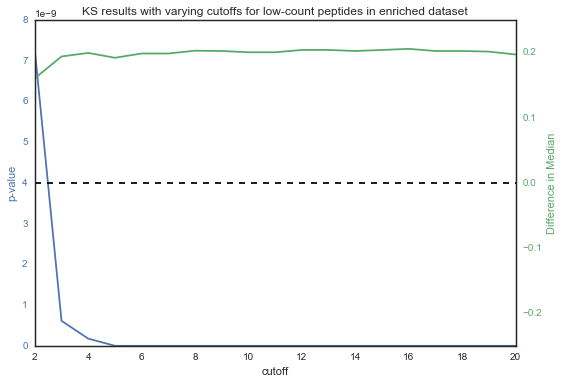

In [58]:
fig, ax1 = plt.subplots()

c1 = sns.color_palette()[0]
ax1.plot(dat1['cutoff'], dat1['pval'], color=c1)
ax1.set_ylabel('p-value', color=c1)
#ax1.set_ylim(0, .00023)
for tl in ax1.get_yticklabels():
    tl.set_color(c1)

ax2 = ax1.twinx()
c2 = color=sns.color_palette()[1]
ax2.plot(dat1['cutoff'], dat1['med_d'], color=c2)
ax2.set_ylabel('Difference in Median', color=c2)
ax2.set_ylim(-.25, .25)
ax2.plot((0, 300), (0,0), 'k--')
for tl in ax2.get_yticklabels():
    tl.set_color(c2)
    
plt.title('KS results with varying cutoffs for low-count peptides in enriched dataset')
ax1.set_xlim(2, 20)
ax1.set_xlabel('cutoff');

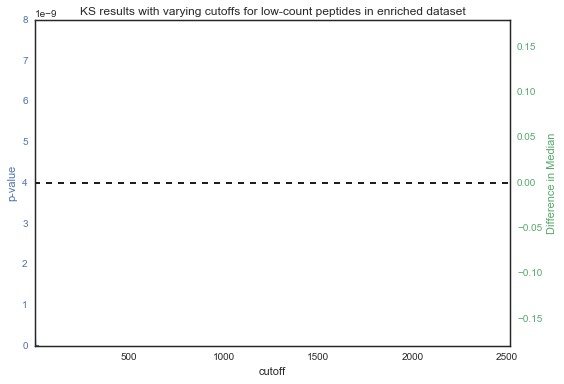

In [59]:
fig, ax1 = plt.subplots()

c1 = sns.color_palette()[0]
ax1.plot(dat1['cutoff'], dat1['pval'], color=c1)
ax1.set_ylabel('p-value', color=c1)
#ax1.set_ylim(0, .00023)
for tl in ax1.get_yticklabels():
    tl.set_color(c1)

ax2 = ax1.twinx()
c2 = color=sns.color_palette()[1]
ax2.plot(dat1['cutoff'], dat1['med_d'], color=c2)
ax2.set_ylabel('Difference in Median', color=c2)
ax2.set_ylim(-.18, .18)
ax2.plot((0, 2516), (0,0), 'k--')
for tl in ax2.get_yticklabels():
    tl.set_color(c2)
    
plt.title('KS results with varying cutoffs for low-count peptides in enriched dataset')
ax1.set_xlim(2, 2516)
ax1.set_xlabel('cutoff');